In [1]:
#
#   ___                  _                
#  / _/______ ____  ____(_)__ _______     
# / _/ __/ _ `/ _ \/ __/ (_-</ __/ _ \    
#/_//_/  \_,_/_//_/\__/_/___/\__/\___/    
# ___ _____(_)__ ___ ____  / /_(_)       
# / _ `/ __/ (_-</ _ `/ _ \/ __/ /        
# \_, /_/ /_/___/\_,_/_//_/\__/_/         
#/___/
#
#Samee Lab @ Baylor College Of Medicine
#francisco.grisanticanozo@bcm.edu

In [55]:
import psutil
import platform
from datetime import datetime

print("="*40, "System Information", "="*40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")

======================================== System Information ========================================
System: Linux
Node Name: martinlab-bobbyd
Release: 4.15.0-142-generic
Version: #146-Ubuntu SMP Tue Apr 13 01:11:19 UTC 2021
Machine: x86_64


In [56]:
#Load libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import sys
import pandas as pd
import warnings
import seaborn as sb
import sklearn
import tqdm
import scanpy as sc
import anndata
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.base import RegressorMixin
from sklearn.base import ClassifierMixin
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [57]:
#sys.path.append('./STANN/')
from STANN.STANN.models import STANN, BaseSupervisedPCA
import STANN.STANN.utils as utils

In [58]:
import tensorflow as tf
import tensorflow.keras as keras
print(f'tensorflow=={tf.__version__} \nkeras=={tf.keras.__version__}')

tensorflow==2.2.0 
keras==2.3.0-tf


In [59]:
#Reproducibility
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

In [62]:
################LOAD DATA###################

# check to see which data
print("[INFO] loading training data...")
adata_train = sc.read_h5ad("../Data/Tabula_Sapiens/adata_train.h5ad")

print("[INFO] loading predict data...")
adata_predict = sc.read_h5ad("../Data/Tabula_Sapiens/adata_predict.h5ad")

[INFO] loading training data...
[INFO] loading predict data...


In [64]:
###############TRAIN TEST SPLIT###################


X_train, Y_train, X_predict = utils.organize_data(adata_train=adata_train,
                                            adata_predict=adata_predict)


X_train_scaled , scaler_train = utils.min_max(X=X_train)

X_predict_scaled , scaler_predict = utils.min_max(X=X_predict)

Y_train_dummy,Y_train_ohe,encoder = utils.label_encoder(Y_train=Y_train)

x_train, x_test, y_train, y_test = utils.get_train_test_split(X_train_scaled,
                                                    Y_train_ohe,
                                                    test_size=0.10, 
                                                    random_state=40)

class_weights = utils.get_class_weights(Y_train_ohe=y_train)
class_weights = {i : class_weights[i] for i in range(len(np.unique(Y_train)))}

/home/franciscog/.conda/envs/STANN/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[INFO] X_train shape=(11548, 15000)
[INFO] y_train shape=(11548, 6)

[INFO] X_test shape=(1284, 15000)
[INFO] y_test shape=(1284, 6)


/home/franciscog/.conda/envs/STANN/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[5 4 3 ... 4 3 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [1]:
################RUN SUPERVISED PCA###################

bspca = None

bspca = BaseSupervisedPCA(model=LogisticRegression(multi_class="multinomial",
                                              class_weight=class_weights,
                                              solver='lbfgs'),
                                              n_components=50)


_scores,_scores_balanced = bspca.rank_features(np.array(X_train),
                                                         Y_train_dummy,
                                                         class_weights)

_scores_balanced_pd = pd.DataFrame({'index_position':np.arange(0,np.array(X_train).shape[1]),
          '_scores': _scores_balanced})

_scores_pd = pd.DataFrame({'index_position':np.arange(0,np.array(X_train).shape[1]),
          '_scores': _scores})

_scores_balanced_pd.to_csv('../Data/Tabula_Sapiens/features_scores_balanced.csv')

_scores_pd.to_csv('../Data/Tabula_Sapiens/features_scores.csv')
    
                                                        
X = bspca.subset_features(x_train,
                 _scores_balanced,
                 155)


bspca.fit(X,np.argmax(y_train, axis=1))

NameError: name 'BaseSupervisedPCA' is not defined

In [66]:
################GET SUPERVISED PCA TRANSFORMATIONS###################

x_train_transformed = bspca.get_transformed_data(X)

x_test_subset = bspca.subset_features(x_test,
                 _scores_balanced,
                 15000)

x_test_transformed = bspca.get_transformed_data(x_test_subset)

X_predict_subset = bspca.subset_features(X_predict_scaled,
                 _scores_balanced,
                 15000)

X_predict_transformed = bspca.get_transformed_data(X_predict_subset)

In [68]:
################RUN STANN###################

model = STANN(act_fun='relu',
              first_dense=300,
              second_dense=200,
              learning_rate=0.01,
              input_dim=x_train_transformed.shape[1],
              output_dim=len(adata_train.obs.celltype.unique()))

print(model)

es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                      mode='min', 
                                      verbose=1,
                                      patience=30)

history = model.fit(x_train_transformed, 
                    y_train, 
                    validation_data=(x_test_transformed, y_test),
                    epochs=10,
                    class_weight=class_weights,
                    callbacks=[es],verbose=1)

Epoch 1/10
361/361 [==============================] - 44s 121ms/step - loss: 1.1578 - accuracy: 0.6583 - val_loss: 0.6232 - val_accuracy: 0.8840
Epoch 2/10
361/361 [==============================] - 44s 121ms/step - loss: 0.4318 - accuracy: 0.9146 - val_loss: 0.2424 - val_accuracy: 0.9416
Epoch 3/10
361/361 [==============================] - 43s 119ms/step - loss: 0.2170 - accuracy: 0.9571 - val_loss: 0.1380 - val_accuracy: 0.9626
Epoch 4/10
361/361 [==============================] - 43s 118ms/step - loss: 0.1374 - accuracy: 0.9724 - val_loss: 0.1046 - val_accuracy: 0.9704
Epoch 5/10
361/361 [==============================] - 43s 118ms/step - loss: 0.0995 - accuracy: 0.9797 - val_loss: 0.0867 - val_accuracy: 0.9759
Epoch 6/10
361/361 [==============================] - 45s 124ms/step - loss: 0.0761 - accuracy: 0.9838 - val_loss: 0.0776 - val_accuracy: 0.9766
Epoch 7/10
361/361 [==============================] - 44s 123ms/step - loss: 0.0607 - accuracy: 0.9869 - val_loss: 0.0733 - val_ac

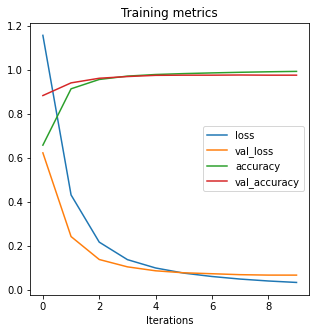

In [69]:
fig, axs = plt.subplots(figsize=(5,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training metrics')
plt.xlabel('Iterations')
plt.legend()

In [73]:
utils.print_metrics(model=model,
                  x_train=x_train_transformed,
                  y_train=y_train,
                  x_test=x_test_transformed,
                  y_test=y_test)


predictions = utils.make_predictions(model=model,
                     X_predict=X_predict_transformed,
                     encoder=encoder,
                     adata_predict=adata_predict,
                     probabilities=True,
                     save=False)

[INFO] Accuracy -- Train: 0.995, Test: 0.977
[INFO] ROC -- Train: 1.000, Test: 0.998


# Test predictions metrics

In [71]:
from sklearn.metrics import accuracy_score

In [72]:
accuracy_score(predictions['celltype'],predictions['STANN_predictions'])

0.9715876367824918

In [9]:
################ SAVE PREDICTIONS ###################

predictions.to_csv(str(args["output"])+str(args["project"])+"_predictions.csv")
_scores_balanced_pd.to_csv(str(args["output"])+str(args["project"])+'_features_scores_balanced.csv')
_scores_pd.to_csv(str(args["output"])+str(args["project"])+'_features_scores.csv')

################ SAVE MODEL ###################

print("[INFO] saving .h5 model ...")
model.save(str(args["output"])+str(args["project"])+"_model.h5")